In [104]:
import numpy as np
import sys
import os
import do_mpc
import casadi
import matplotlib.pyplot as plt
import matplotlib as mpl

# Customizing Matplotlib:
mpl.rcParams['axes.grid'] = True


## Configure the model

In [105]:
model = do_mpc.model.Model("continuous")

In [106]:
# states _x
phi_1 = model.set_variable(var_type="_x", var_name="phi_1", shape=(1, 1))
phi_2 = model.set_variable(var_type="_x", var_name="phi_2", shape=(1, 1))
phi_3 = model.set_variable(var_type="_x", var_name="phi_3", shape=(1, 1))
dphi = model.set_variable(var_type="_x", var_name="dphi", shape=(3, 1))
phi_1_m = model.set_variable(var_type="_x", var_name="phi_1_m", shape=(1,1))
phi_2_m = model.set_variable(var_type="_x", var_name="phi_2_m", shape=(1,1))

In [107]:
# inputs _u
phi_m_1_set = model.set_variable(var_type="_u", var_name="phi_m_1_set")
phi_m_2_set = model.set_variable(var_type="_u", var_name="phi_m_2_set")

In [108]:
# parameters _p
Theta_1 = model.set_variable('_p', 'Theta_1')
Theta_2 = model.set_variable('_p', 'Theta_2')
Theta_3 = model.set_variable('_p', 'Theta_3')
c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

In [109]:
# rhs (first order differential equasions of _x)
ddphi = casadi.vertcat(
    -c[0]/Theta_1*(phi_1-phi_1_m)-c[1]/Theta_1*(phi_1-phi_2)-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi_2-phi_1)-c[2]/Theta_2*(phi_2-phi_3)-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi_3-phi_2)-c[3]/Theta_3*(phi_3-phi_2_m)-d[2]/Theta_3*dphi[2],
)
tau = 1e-2
model.set_rhs('phi_1', dphi[0])
model.set_rhs('phi_2', dphi[1])
model.set_rhs('phi_3', dphi[2])
model.set_rhs('dphi', ddphi)
model.set_rhs('phi_1_m', 1/tau*(phi_m_1_set - phi_1_m))
model.set_rhs('phi_2_m', 1/tau*(phi_m_2_set - phi_2_m))

In [110]:
model.setup()

## Configure the MPC 

#### Set parameters

In [111]:
mpc = do_mpc.controller.MPC(model)

mpc.set_param(
    n_horizon = 20,
    t_step = 0.1,
    n_robust = 1,
    store_full_solution = True,
)

#### Create objective function

**lterm** - lagrange term, penalty which is a sum of each state (k - N)

**mterm** - meyer term, penalty for the terminal state which is N+1

**rterm** - penalty for control inputs, controlled by R matrix

In [112]:
mterm = phi_1**2 + phi_2**2 + phi_3**2
lterm = phi_1**2 + phi_2**2 + phi_3**2

mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(
    phi_m_1_set=1e-2,
    phi_m_2_set=1e-2
)

#### Constraints

In [113]:
mpc.bounds['lower', '_x', 'phi_1'] = -2*np.pi
mpc.bounds['lower', '_x', 'phi_2'] = -2*np.pi
mpc.bounds['lower', '_x', 'phi_3'] = -2*np.pi

mpc.bounds['upper', '_x', 'phi_1'] = 2*np.pi
mpc.bounds['upper', '_x', 'phi_2'] = 2*np.pi
mpc.bounds['upper', '_x', 'phi_3'] = 2*np.pi

In [114]:
mpc.bounds['lower', '_u', 'phi_m_1_set'] = -2*np.pi
mpc.bounds['lower', '_u', 'phi_m_1_set'] = -2*np.pi

mpc.bounds['upper', '_u', 'phi_m_1_set'] = 2*np.pi
mpc.bounds['upper', '_u', 'phi_m_1_set'] = 2*np.pi

#### Scaling

Not necessary in this problem, but if s have significantly different magnitude, they should be scaled to the same order of magnitude

In [115]:
mpc.scaling['_x','phi_1'] = 2
mpc.scaling['_x','phi_2'] = 2
mpc.scaling['_x','phi_3'] = 2

#### Uncertain parameters

If the exact value of the parameters is unknown, they can be set during the **model** creation. Now we must provide the optimizer with different possible values for these parameters. MPC will then predict multiple future trajectories (and will choose the one that minimizes the objective function the best ???).

In [116]:
inertia_mass_1 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_2 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_3 = 2.25*1e-4*np.array([1.])

mpc.set_uncertainty_values(
    Theta_1 = inertia_mass_1,
    Theta_2 = inertia_mass_2,
    Theta_3 = inertia_mass_3
)

#### Setup

In [117]:
mpc.setup()

## Simulator

Set theta values as const

In [118]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=0.1)

p_template = simulator.get_p_template()

def p_fun(t_now):
    p_template['Theta_1'] = 2.25e-4
    p_template['Theta_2'] = 2.25e-4
    p_template['Theta_3'] = 2.25e-4
    return p_template

simulator.set_p_fun(p_fun)
simulator.setup()

## Controll loop

#### Set the initial state

In [119]:
x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)
simulator.x0 = x0
mpc.x0 = x0
mpc.set_initial_guess()

#### Visualisation

In [120]:
%%capture

mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='phi_1', axis=ax[0])
    g.add_line(var_type='_x', var_name='phi_2', axis=ax[0])
    g.add_line(var_type='_x', var_name='phi_3', axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='phi_m_1_set', axis=ax[1])
    g.add_line(var_type='_u', var_name='phi_m_2_set', axis=ax[1])


ax[0].set_ylabel('angle position [rad]')
ax[1].set_ylabel('motor angle [rad]')
ax[1].set_xlabel('time [s]')

#### Running the simulator

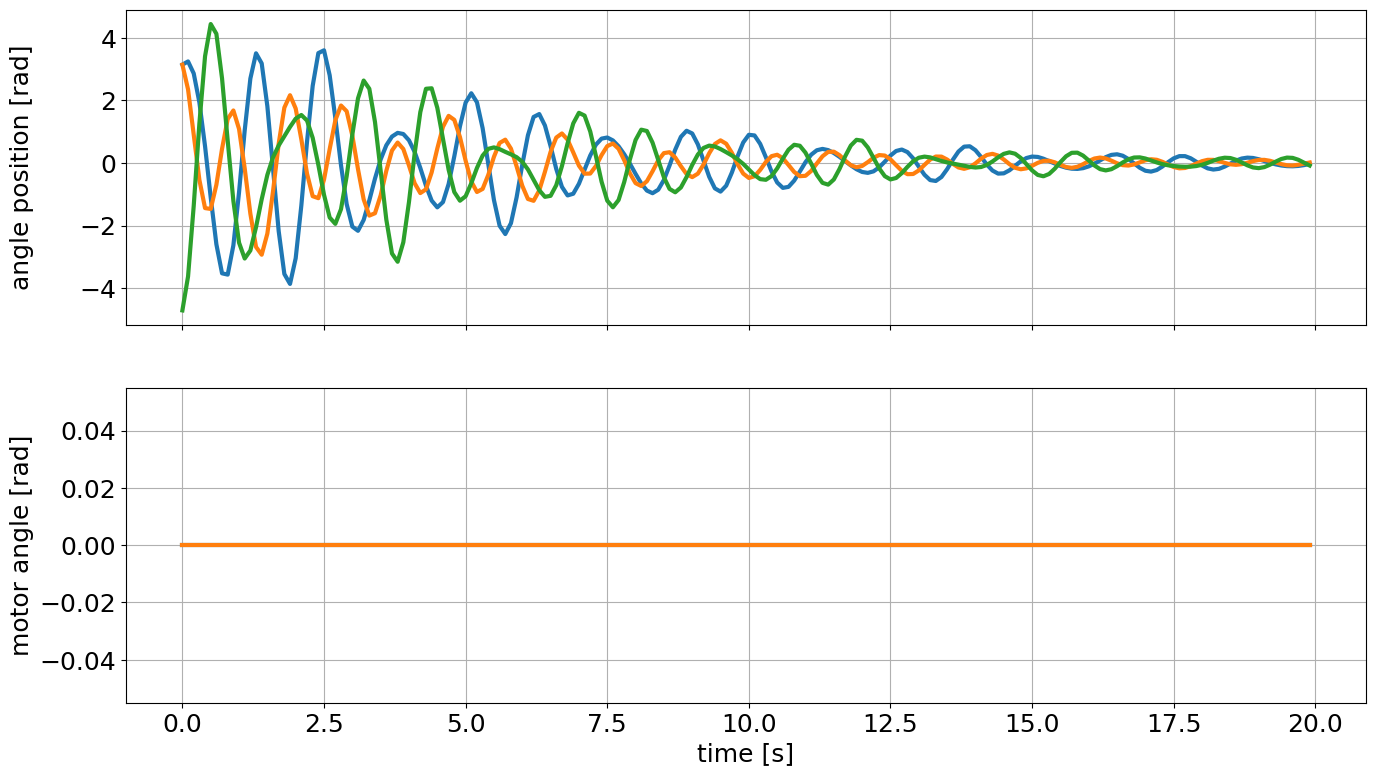

In [121]:
u0 = np.zeros((2,1))
for i in range(200):
    simulator.make_step(u0)

sim_graphics.plot_results()
sim_graphics.reset_axes()
fig